# Trabajo Práctico Final - Neurociencia Computacional

## Alumnos:
### - Bosetti, Franco - Legajo 61654
### - Martone, Gonzalo - Legajo 62141

## Dataset Utilizado:
### Steinmetz dataset
#### Link: https://compneuro.neuromatch.io/projects/neurons/README.html#steinmetz
#### Jupyter Notebook: https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/projects/neurons/load_steinmetz_decisions.ipynb#scrollTo=8r8bxGqF9ytt

### Descripción de los datos:

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

The `spks` array in the Steinmetz dataset is a three-dimensional array because it represents the neural spike data in a way that captures three important aspects of the data:  
* Neurons: The first dimension represents different neurons. Each neuron has its own pattern of spiking activity, so it's important to keep the data from each neuron separate.  
* Trials: The second dimension represents different trials. In the context of the Steinmetz dataset, a trial corresponds to a single instance of the mouse performing the task. The neural activity can vary from trial to trial, so it's important to keep the data from each trial separate.  
* Time bins: The third dimension represents different time bins. The neural activity is recorded over time, and each time bin represents the spiking activity in a small window of time. This allows us to see how the neural activity changes over the course of a trial.

### Importamos las librerías necesarias

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import os, requests

### Descargamos los datos

In [45]:
# @title Data retrieval
fname = []
for j in range(3):
  fname.append('./data/steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

### Cargamos los datos y configuramos los parámetros de las figuras

In [46]:
fname = []
for j in range(3):
  fname.append('./data/steinmetz_part%d.npz'%j)
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('./data/steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))
  
# @title Figure settings
from matplotlib import rcParams
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

### Análisis de los datos
#### Creamos un modelo de regresión lineal por cada una de las 39 sesiones del dataset

In [47]:
# Crear un diccionario para almacenar los resultados por ratón
results = []

window_size = 10
stride = 1

# Entrenar un modelo por ratón
for i, dat in enumerate(alldat):
    mouse_name = dat['mouse_name']
    
    # Extraer las variables necesarias
    spks = dat['spks']
    response = dat['response']
    contrast_right = dat['contrast_right']
    contrast_left = dat['contrast_left']
    
    num_windows = (spks.shape[2] - window_size) // stride + 1
    
    windowed_data = []
    for i in range(num_windows):
      window_data = spks[:, :, i * stride:i * stride + window_size]
      window_avg = np.mean(window_data, axis=2)
      windowed_data.append(window_avg)

    windowed_data = np.array(windowed_data)
    
    data_avg = np.stack(windowed_data, axis=2)
    
    X = data_avg.reshape(data_avg.shape[0], -1).T
    
    # Crear DataFrame para las variables de entrada
    X_df = pd.DataFrame(X)
    
    # Agregar las columnas de contrastes como variables independientes
    X_df['contrast_right'] = np.repeat(contrast_right, data_avg.shape[2])
    X_df['contrast_left'] = np.repeat(contrast_left, data_avg.shape[2])
    
    # Variable dependiente
    y = np.repeat(response, data_avg.shape[2])
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)
    
    # Crear el modelo de regresión logística
    model = LogisticRegression(max_iter=300)
    
    # Convert column names to string
    X_train.columns = X_train.columns.astype(str)
    X_test.columns = X_test.columns.astype(str)
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Hacer predicciones
    y_pred = model.predict(X_test)
    
    # Evaluar el modelo
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    # Almacenar los resultados
    results.append({
        'mouse_name': mouse_name,
        'accuracy': accuracy,
        'conf_matrix': conf_matrix,
        'class_report': class_report
    })

### Mostramos las confusion matrix de cada modelo (uno por sesión)

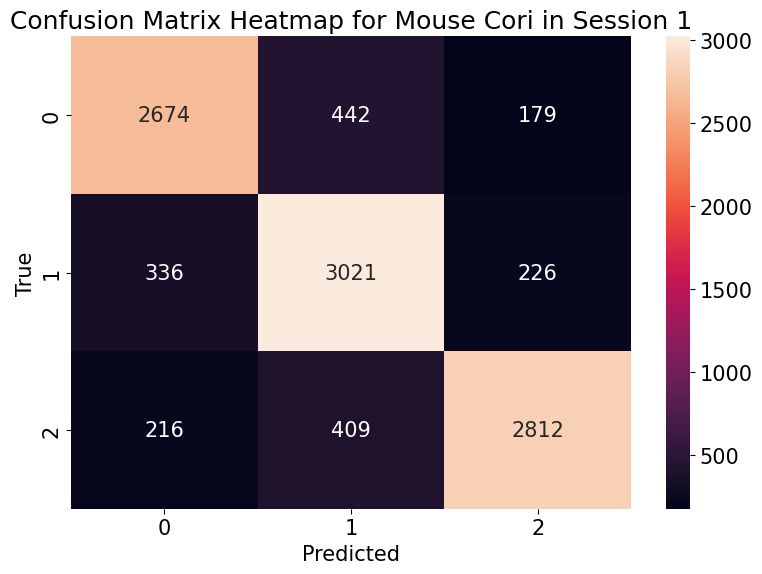

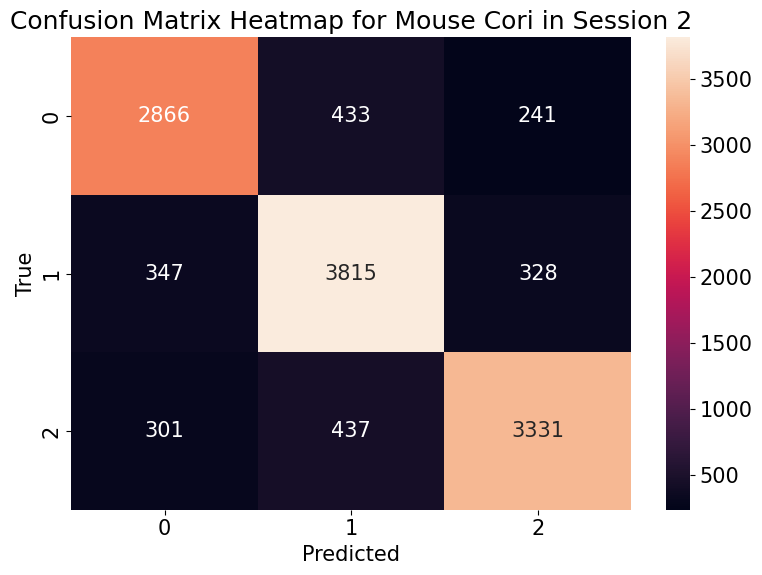

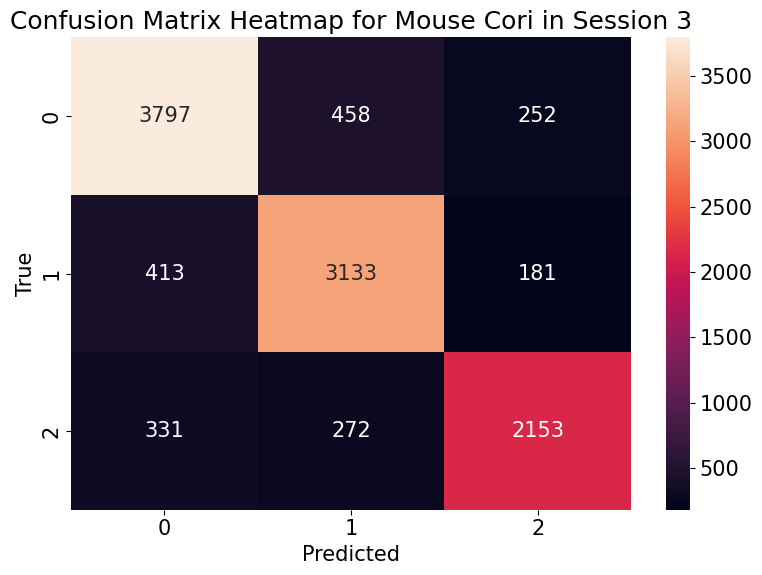

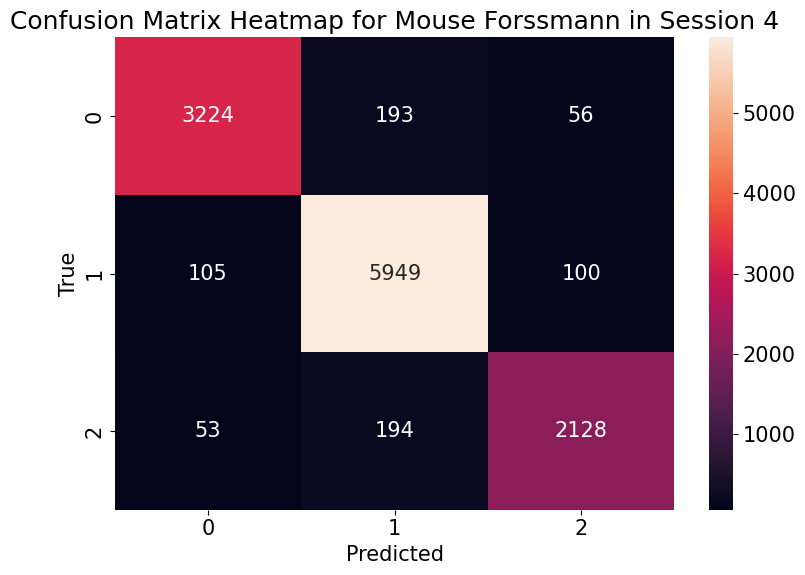

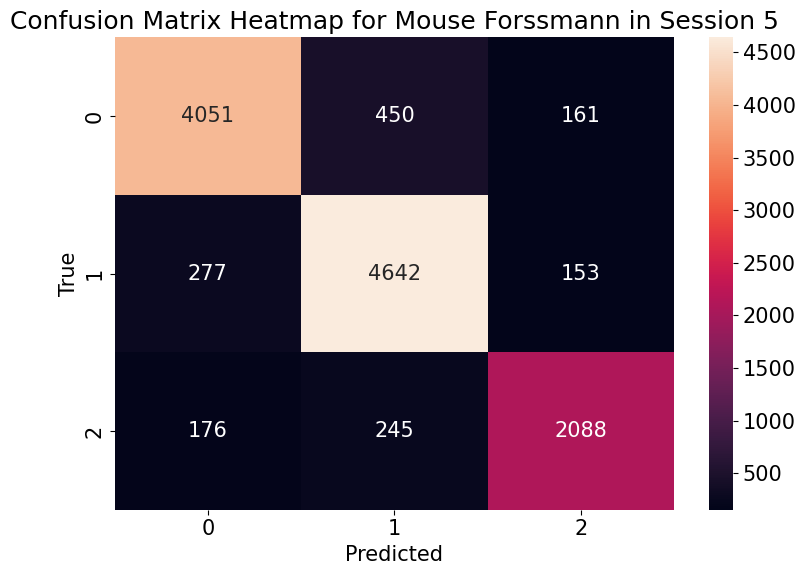

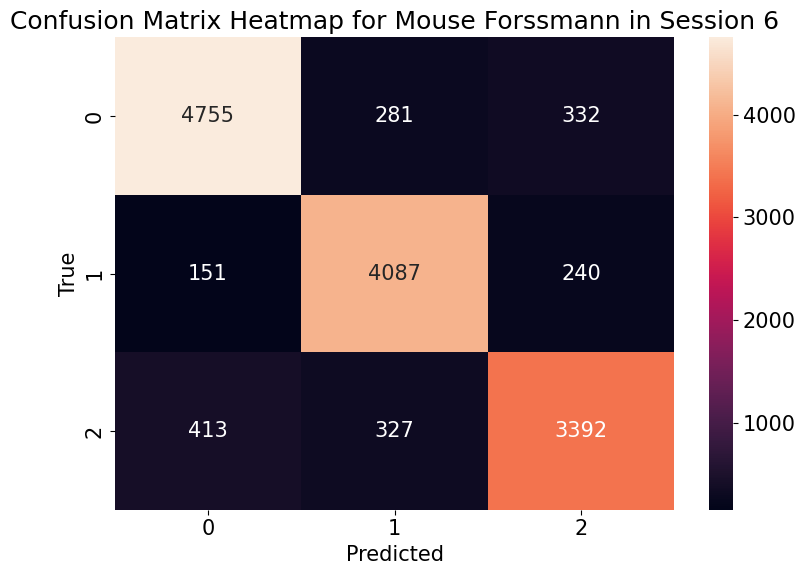

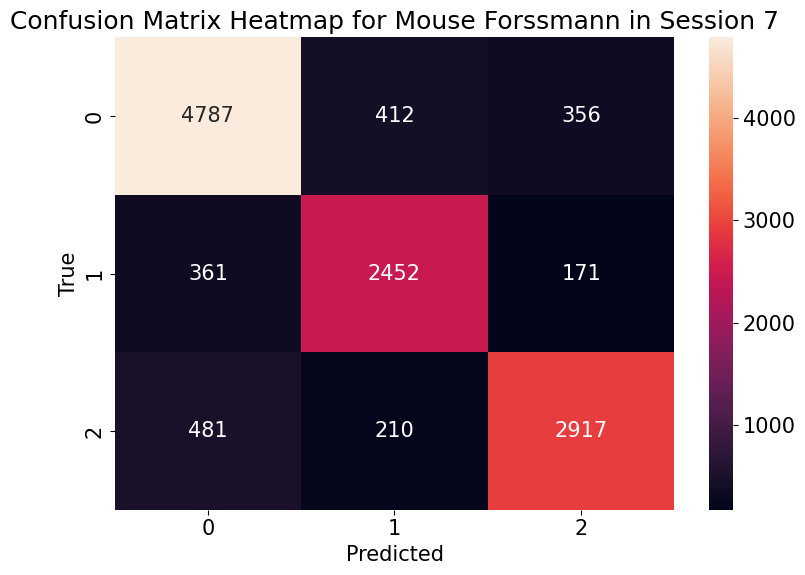

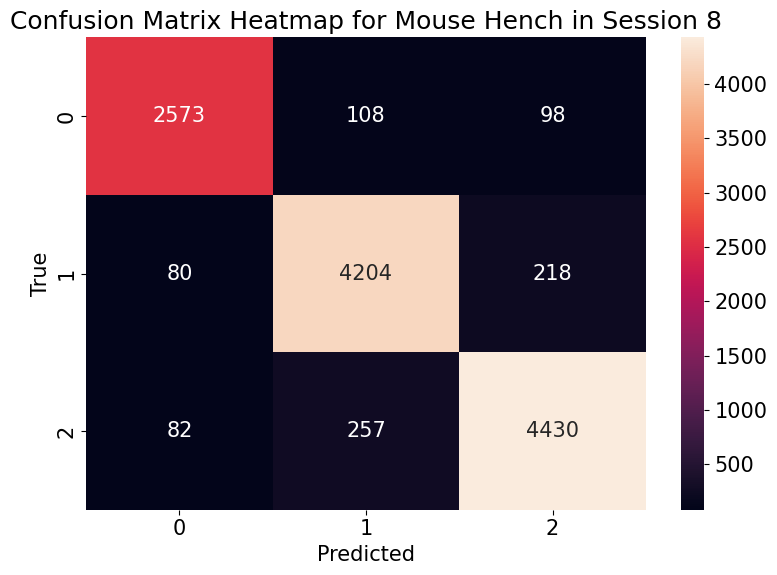

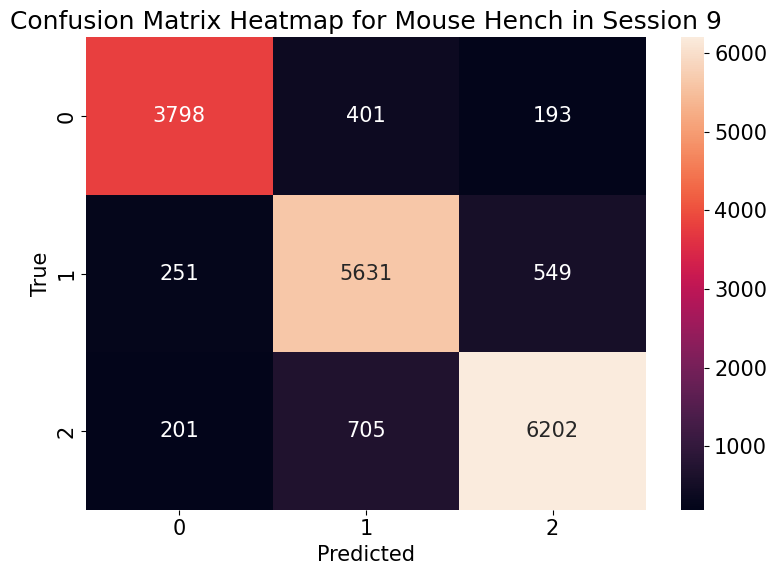

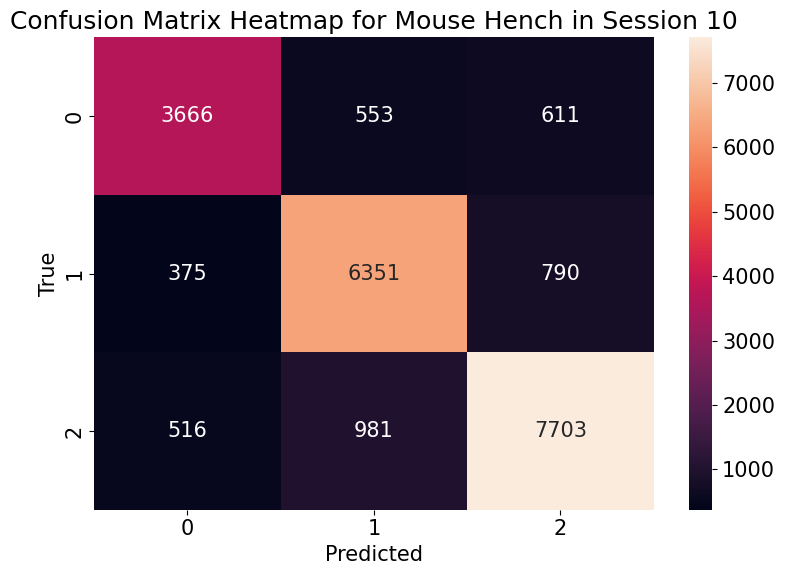

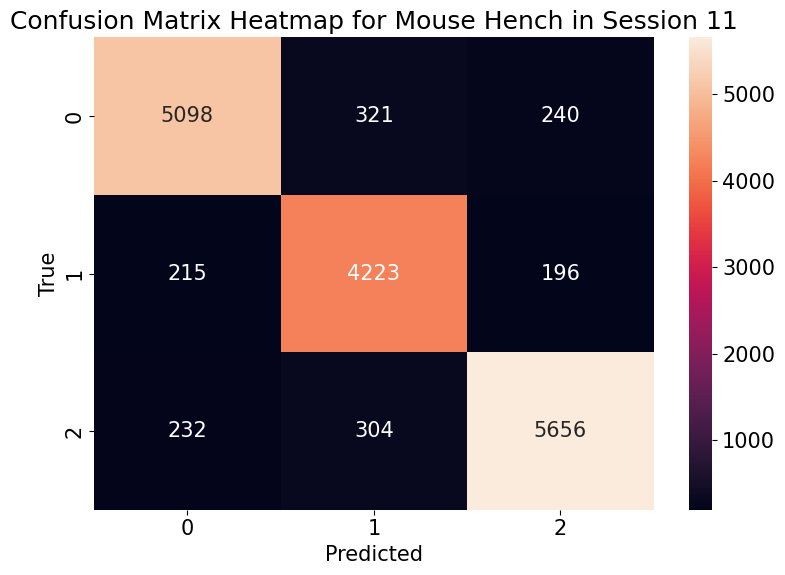

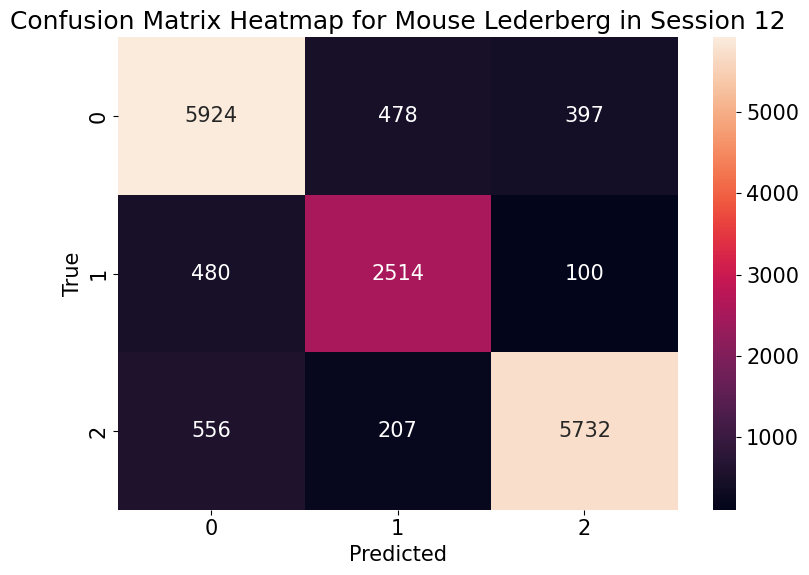

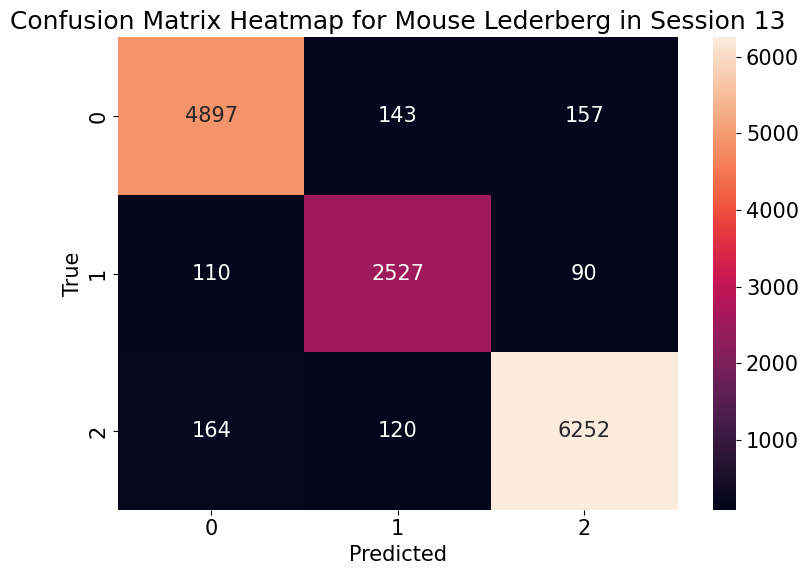

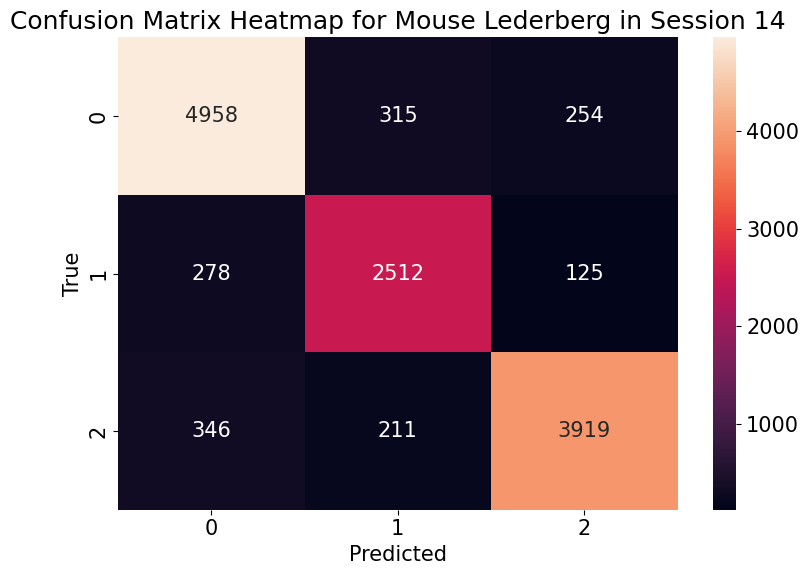

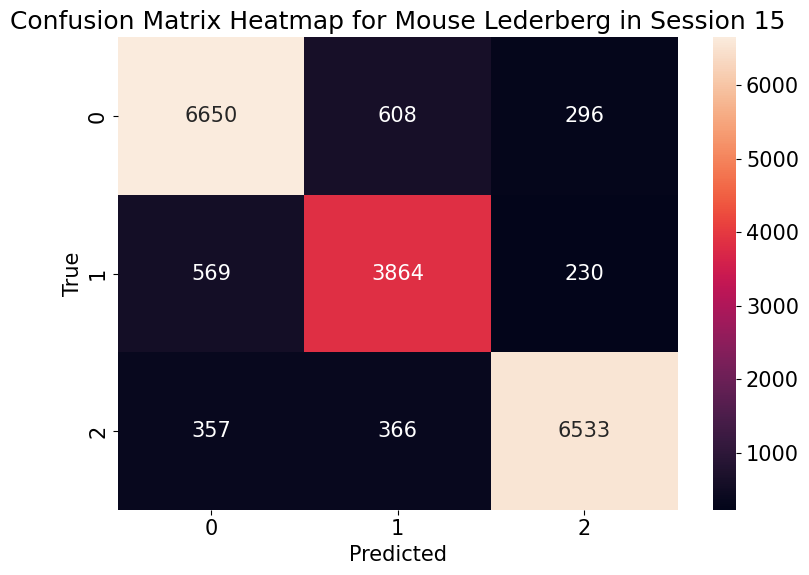

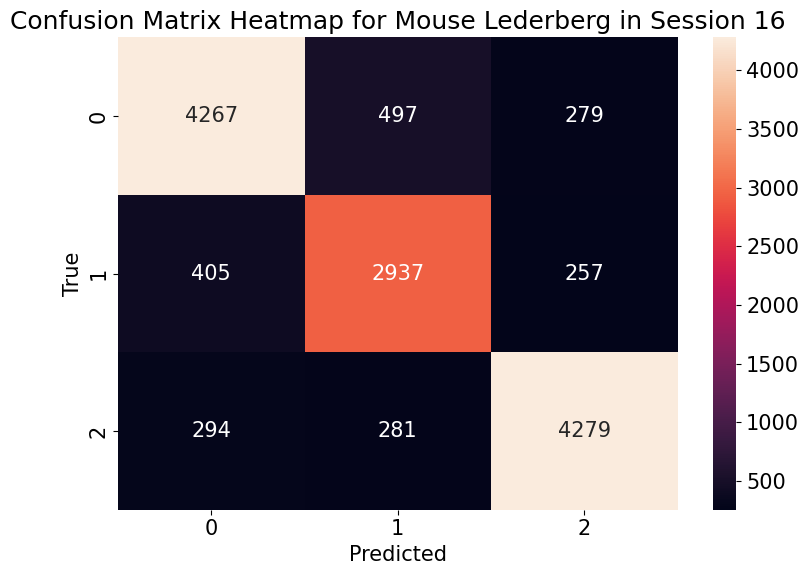

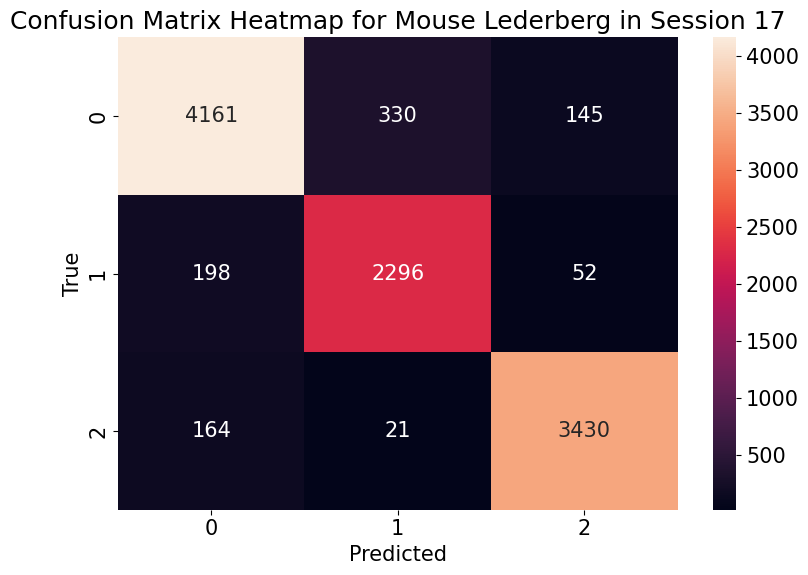

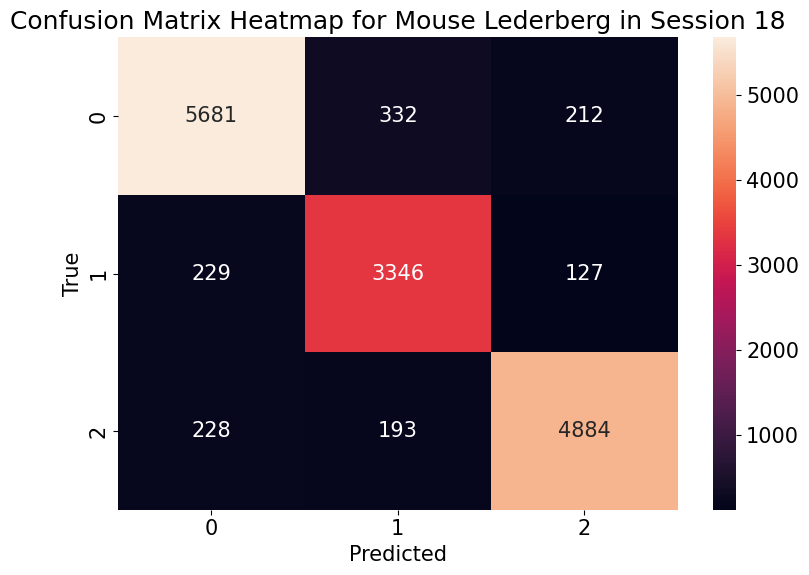

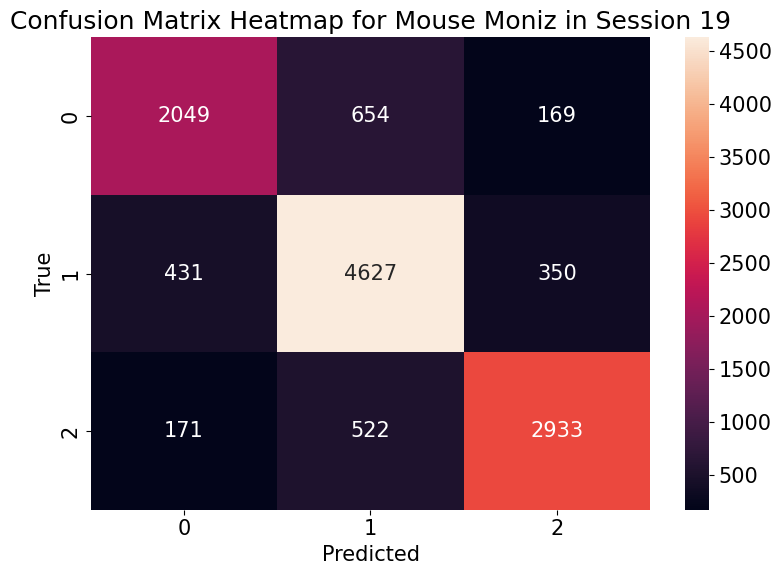

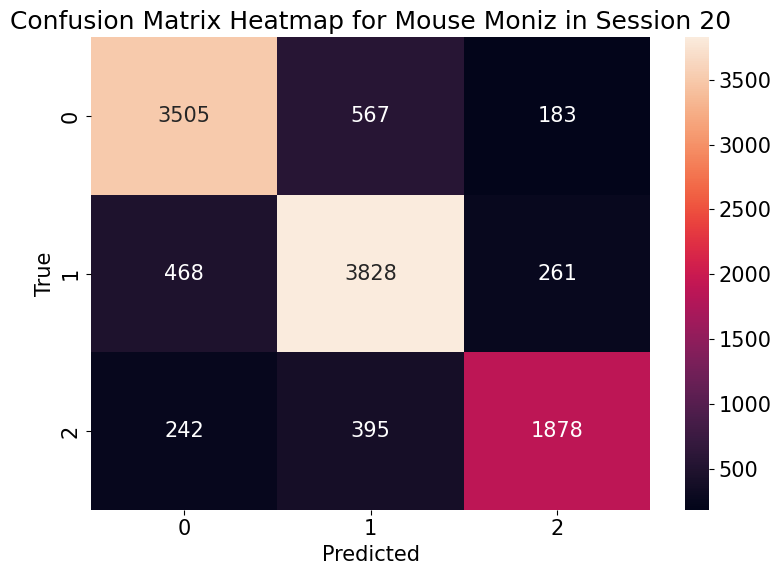

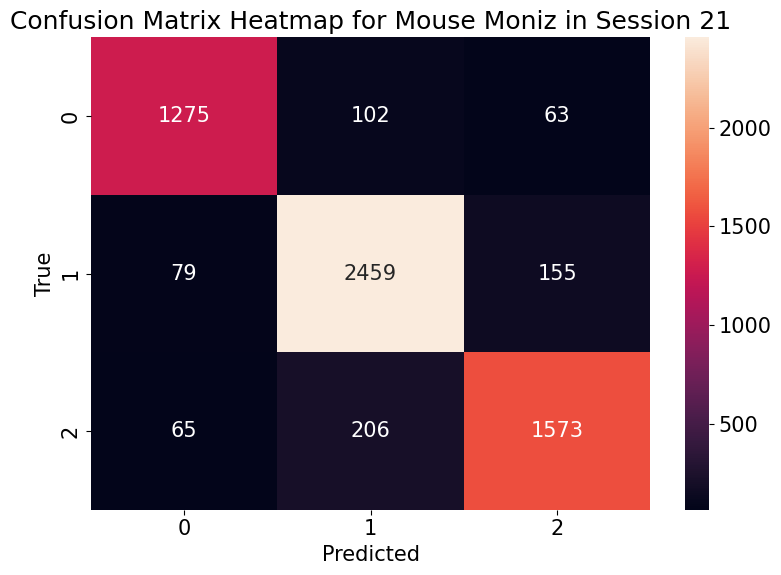

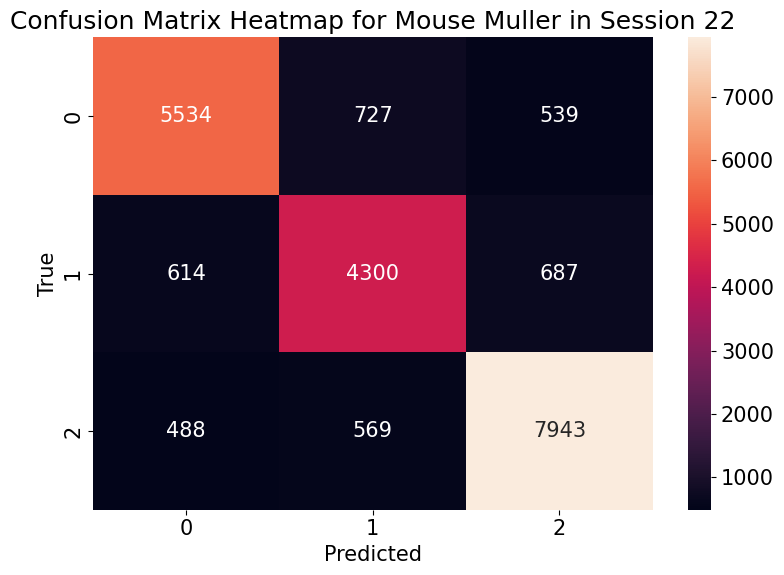

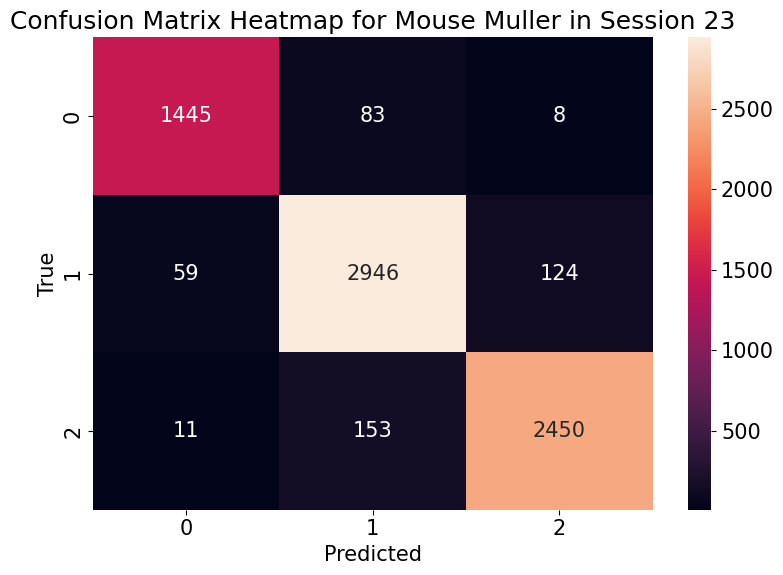

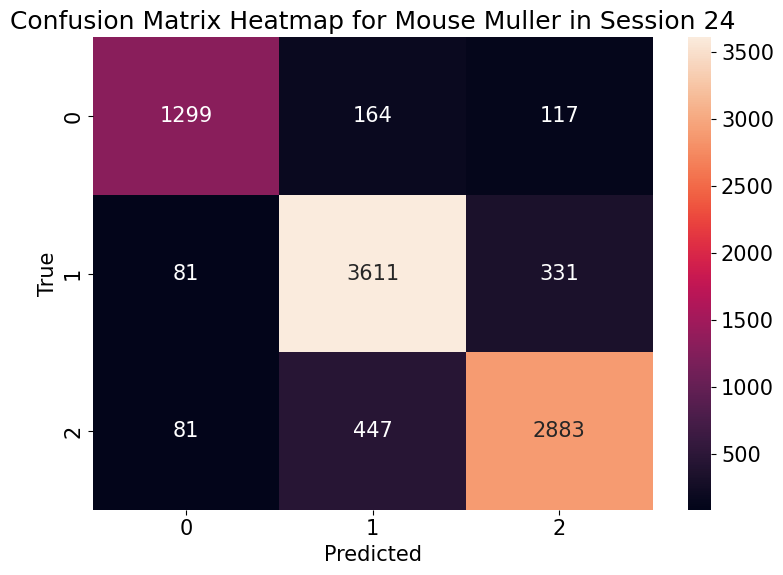

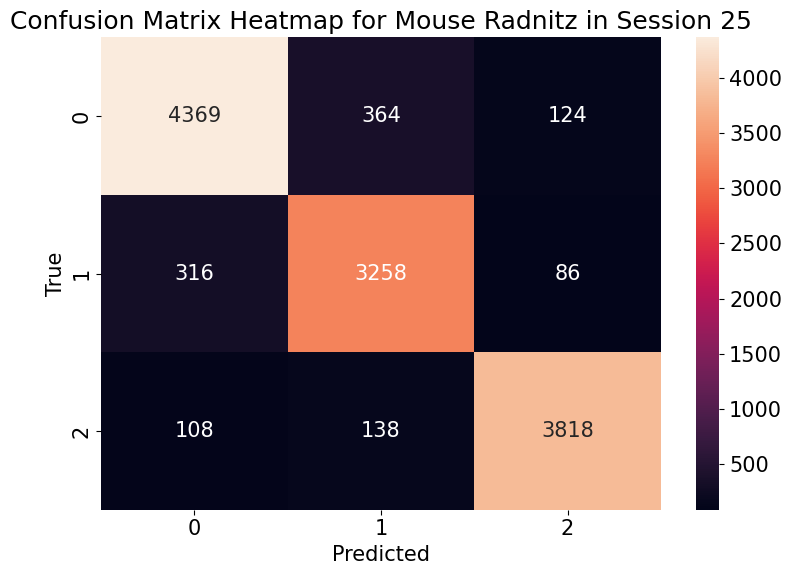

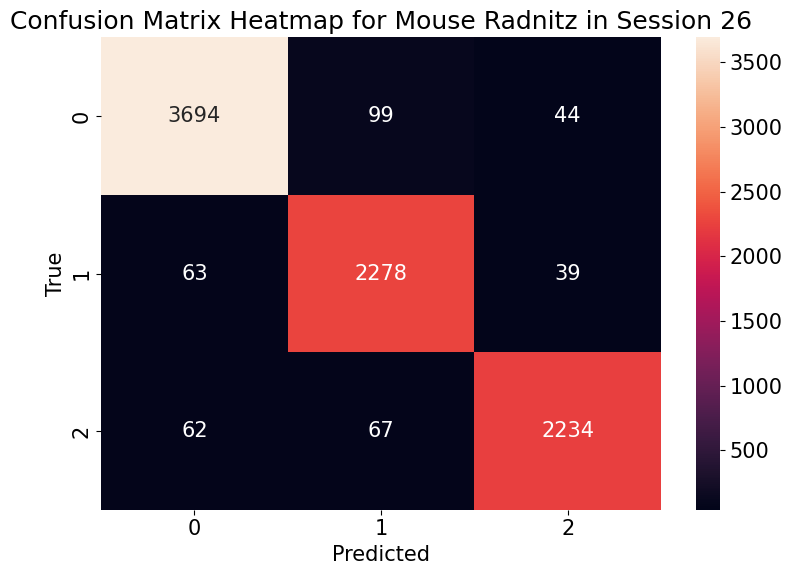

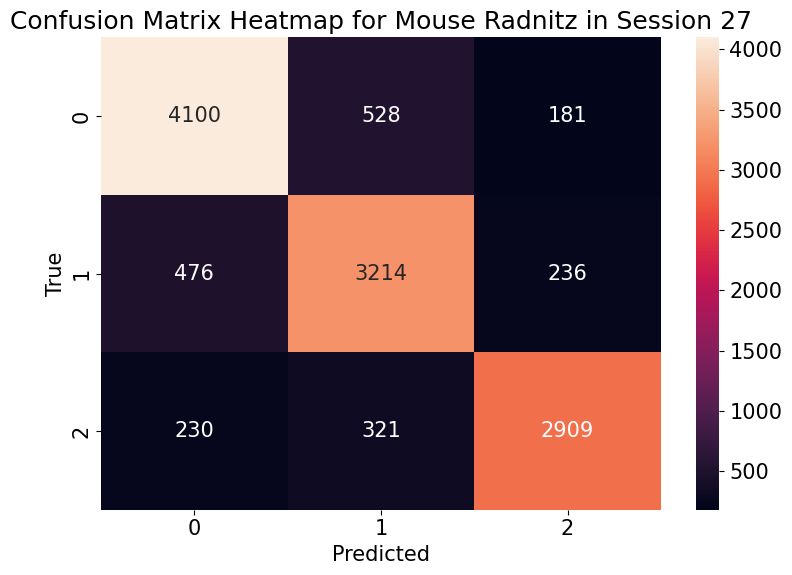

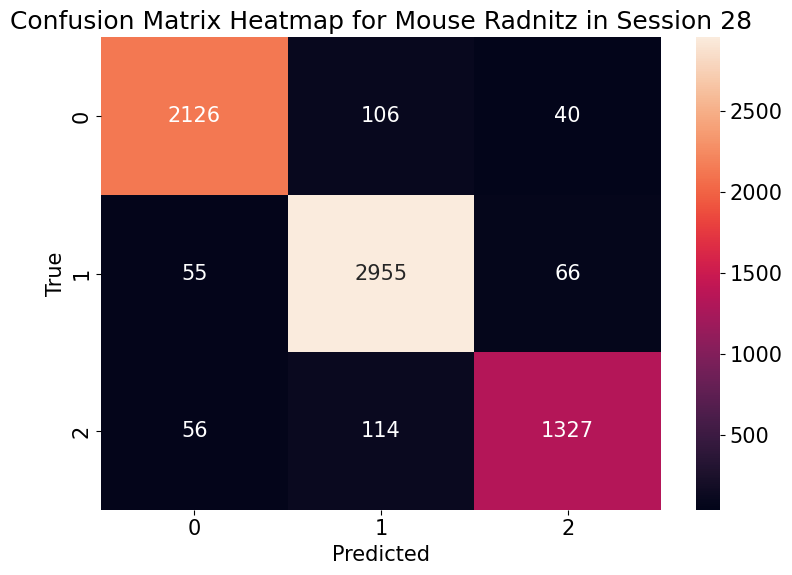

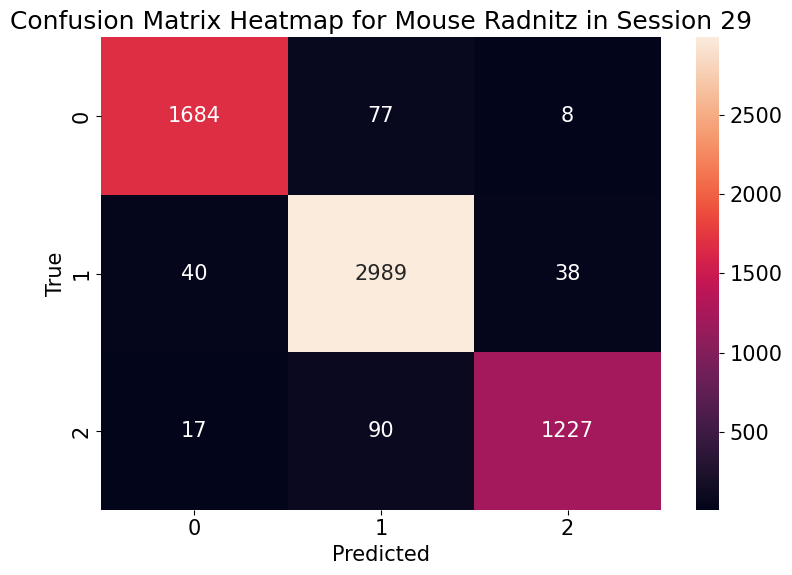

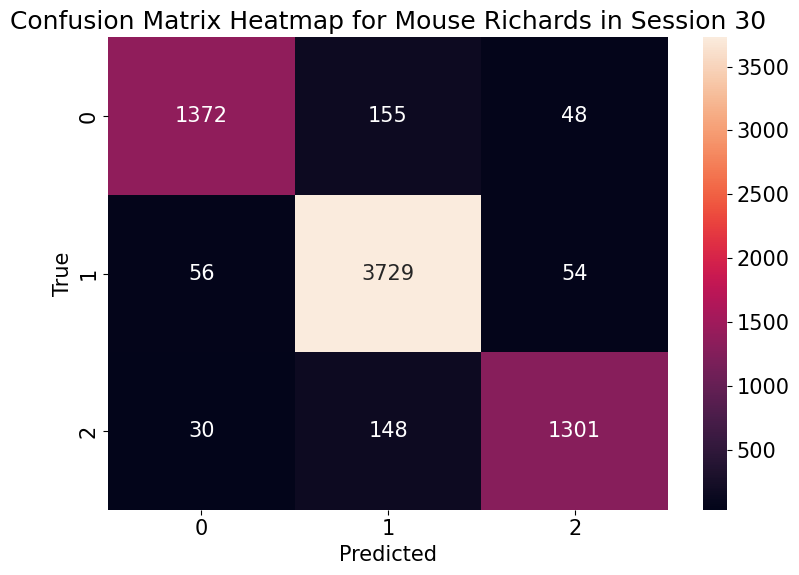

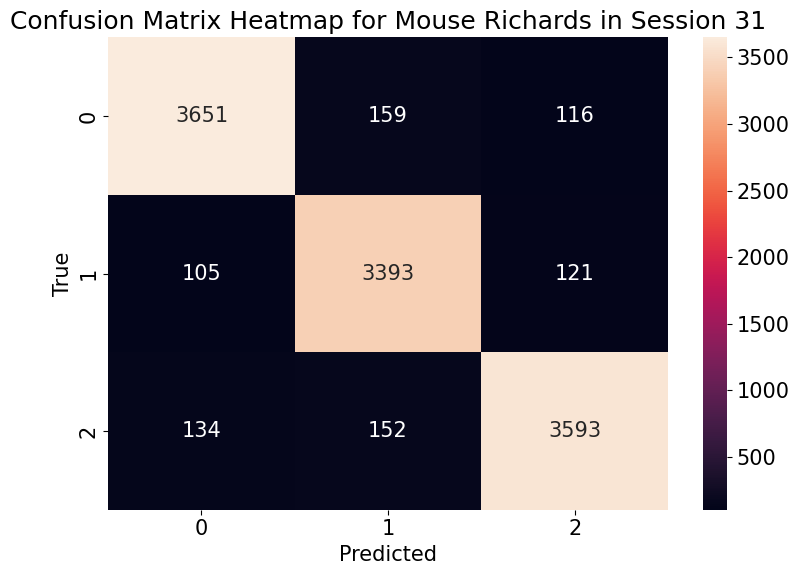

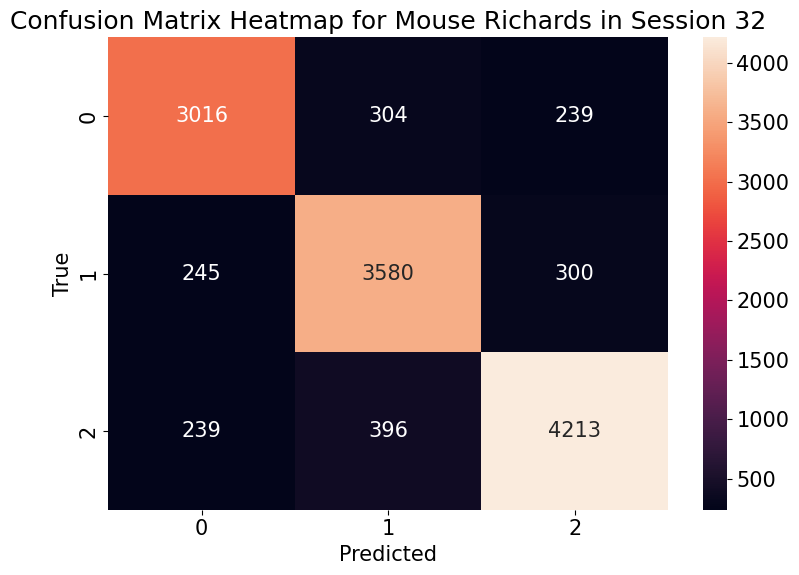

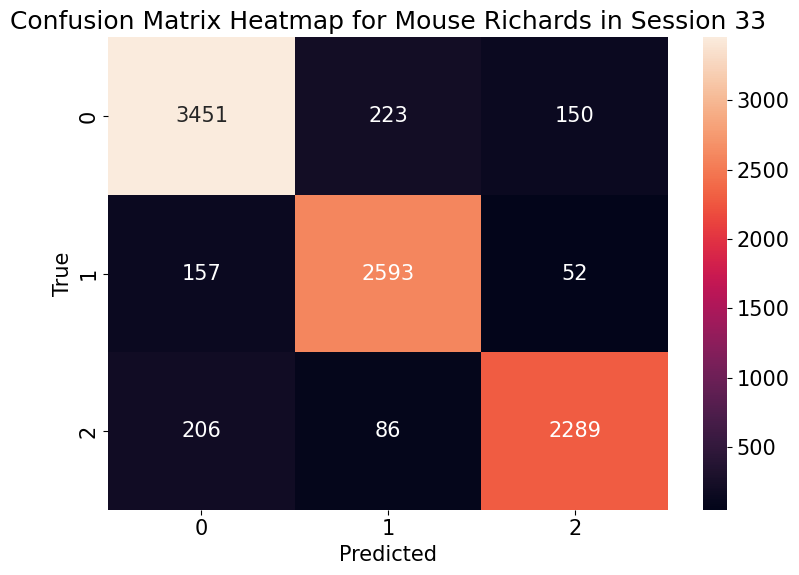

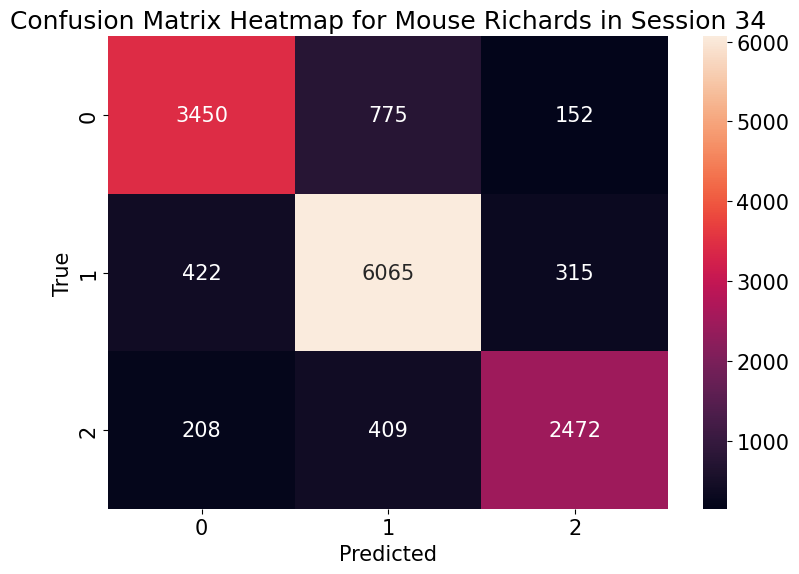

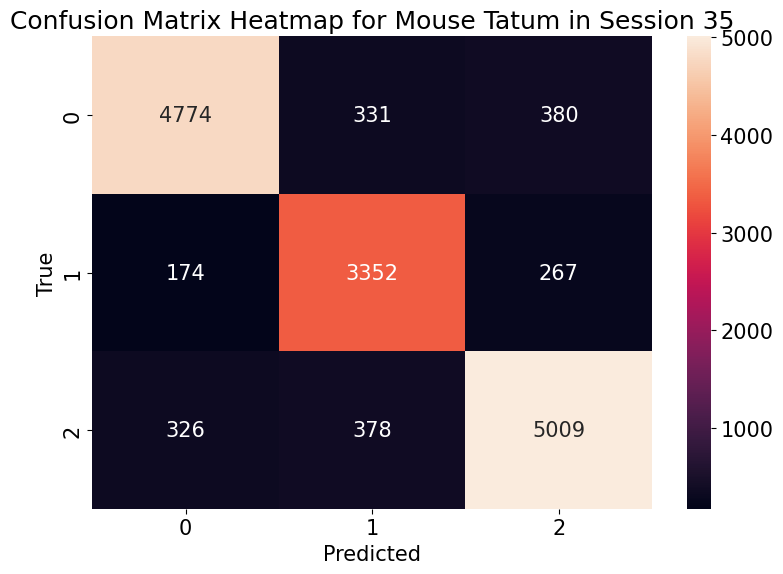

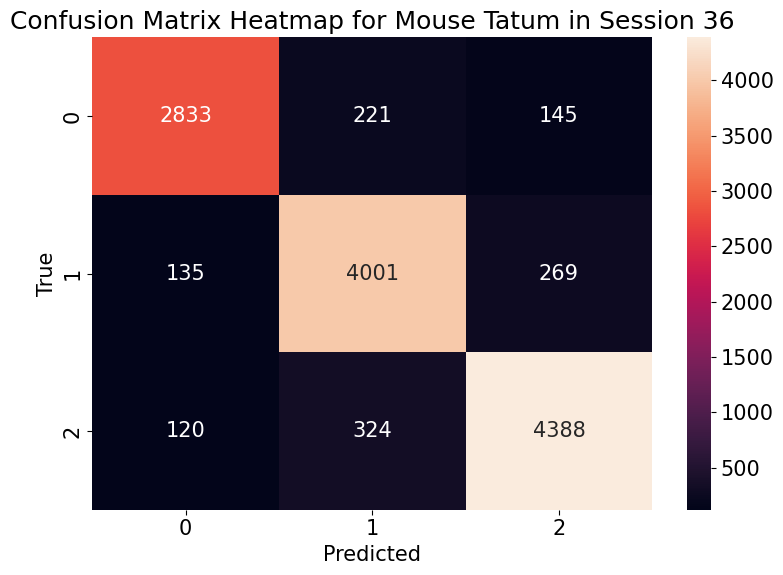

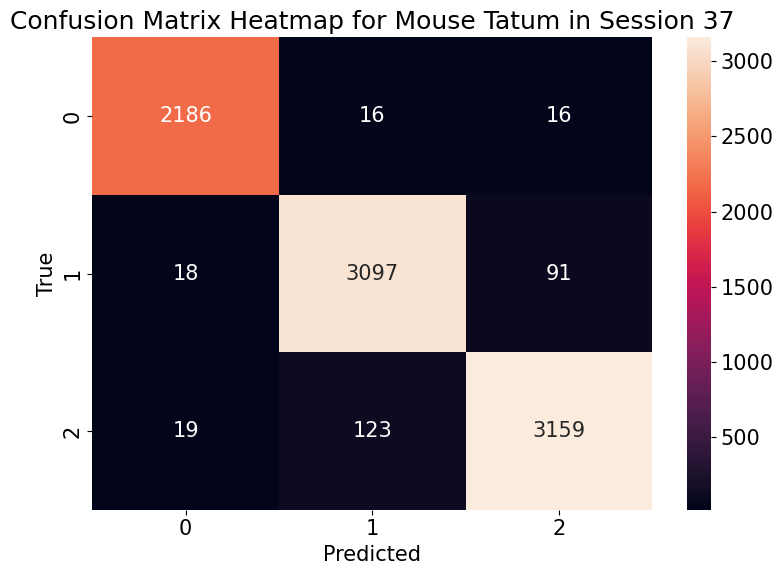

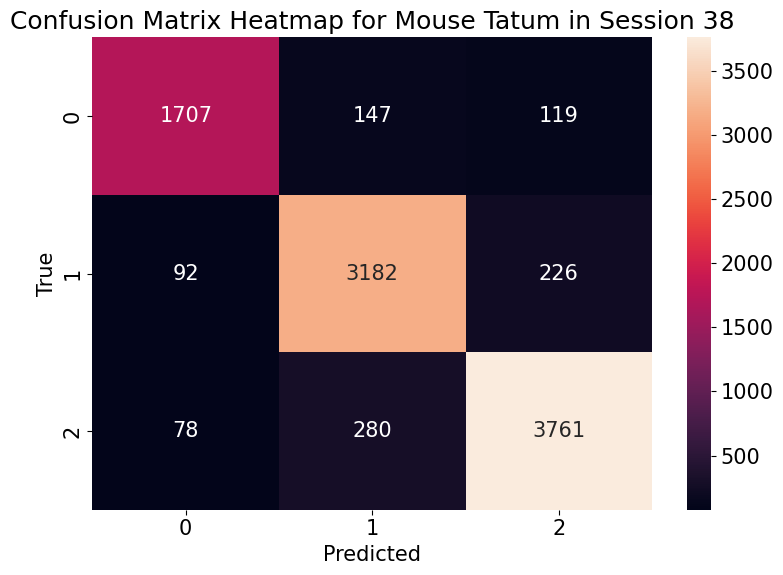

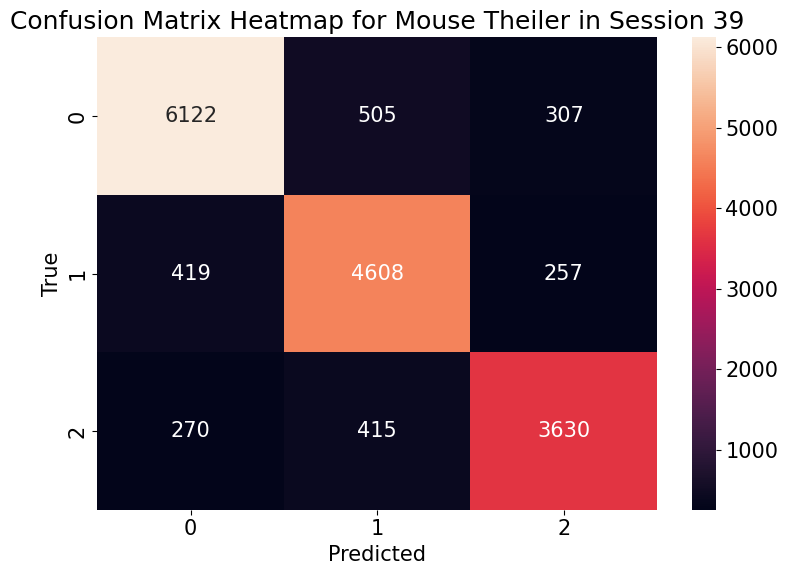

In [48]:
for i, result in enumerate(results):
    plt.figure(figsize=(8, 6))
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap for Mouse ' + result['mouse_name'] + ' in Session ' + str(i+1))
    plt.show()

### Gráfico de barras de la precisión de los modelos por sesión

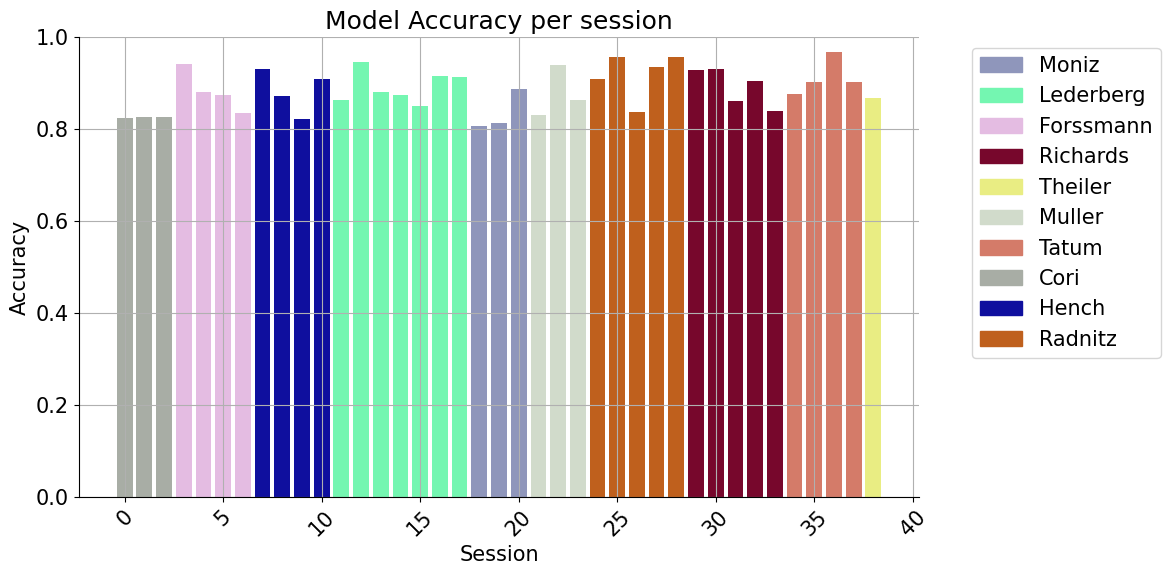

In [49]:
# Extraer las precisiones de cada ratón
indexes = range(len(results))
accuracies = [results[index]['accuracy'] for index in indexes]

# Get unique mouse names
unique_mouse_names = list(set([result['mouse_name'] for result in results]))

# Create a color dictionary
color_dict = {mouse_name: "#" + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)]) for mouse_name in unique_mouse_names}

# Get colors for each bar
bar_colors = [color_dict[result['mouse_name']] for result in results]


# Crear un gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(indexes, accuracies, color=bar_colors)
plt.xlabel('Session')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per session')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True)
patches = [mpatches.Patch(color=color, label=mouse_name) for mouse_name, color in color_dict.items()]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
plt.show()

Obtenemos muy buenos resultados, parecería no ser necesario utilizar redes neuronales.